In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hybrid Deep Learning Model

A Hybrid Deep Learning Model for image classification combines multiple architectures, techniques, or models to leverage their individual strengths and improve the overall performance and generalizability of the system. These hybrid models are designed to address limitations of single architectures by integrating complementary methods or frameworks.

> - Hybrid models are more adaptable to diverse datasets and tasks.
> - Tailored designs can address specific challenges, such as noise in medical imaging or occlusion in object detection.


In [ ]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!unzip -u "/content/drive/MyDrive/birads BUS/cov-noncov.zip" -d "/content/"
print('\n\ndone!')

Archive:  /content/drive/MyDrive/birads BUS/cov-noncov.zip
  inflating: /content/DATA/DATA/0/IM-0115-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0119-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0122-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0125-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0127-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0128-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0129-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0131-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0133-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0135-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0137-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0140-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0141-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0143-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0145-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0149-0001.jpeg  
  inflating: /content/DATA/DATA/0/IM-0151-0001.jpeg  
  inflating: /content/D

##Model

In [ ]:
import cv2
import numpy as np
import glob
import os

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
import os

input_folder="/content/DATA/DATA"

output="/content/op"

splitfolders.ratio(input_folder, output, seed=42, ratio=(0.70,0.15,0.15)) ### train 75%, val 15%, test 10%

Copying files: 3091 files [00:10, 296.29 files/s]


Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, LSTM, GlobalAveragePooling1D, MaxPooling2D, ZeroPadding2D, Conv2D, GlobalAveragePooling2D, Dense, Flatten, Concatenate, Reshape
import matplotlib.pyplot as plt
#transfer learning model

#import various transfer elarning models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow as tf

##Hybrid Model

Multihead attention

In [ ]:
def multihead_attention_layer(input_tensor, num_heads, key_dim, dropout):
    x = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        value_dim=None,
        dropout=dropout,
        use_bias=True,
        output_shape=None,
        attention_axes=None,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        seed=None
    )(input_tensor, input_tensor)  #Self-attention: passing input as query and key value

    return x

MLP block

In [ ]:
# MLP block
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def mlp_block(input_features, hidden_units=[128, 128], dropout_rate=0.3):
    x = input_features
    for units in hidden_units:
        x = Dense(units, activation="relu")(x)
        x = BatchNormalization()(x)  # Add BatchNormalization for better training stability
        x = Dropout(dropout_rate)(x)  # Add Dropout for regularization
    return x

LSTM layer

In [ ]:
def add_lstm_layer(input_tensor, unit):
    lstm_output = LSTM(
        units=64,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        bias_initializer="zeros",
        unit_forget_bias=True,
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.2,
        recurrent_dropout=0.2,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
    )(input_tensor)
    return lstm_output

Model

In [ ]:
IMAGE_SIZE = [224, 224]
CLASS = 2

# VGG16 model
mod = tf.keras.applications.VGG16(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)

# Freeze VGG16 layers
for layer in mod.layers:
    layer.trainable = False

#____________________________________________________________________________________________________________
# Custom CNN blocks
cnn_input = mod.input
cnn1 = Conv2D(16, (3, 3), padding="same", activation="relu")(cnn_input)
cnn1 = BatchNormalization()(cnn1)
cnn1 = MaxPooling2D(pool_size=(2, 2))(cnn1)

cnn2 = Conv2D(32, (3, 3), padding="same", activation="relu")(cnn1)
cnn2 = BatchNormalization()(cnn2)
cnn2 = MaxPooling2D(pool_size=(2, 2))(cnn2)
#_____________________________________________________________________________________________________________

# Flatten outputs
vgg16_flattened = Flatten()(mod.output)
cnn3_flattened = Flatten()(cnn2)
#______________________________________________________________________________________________________________

# Concatenate the features
concatenated_features = Concatenate()([vgg16_flattened, cnn3_flattened])

#______________________________________________________________________________________________________________
# Pass the concatenated features through the MLP block
mlp_features = mlp_block(concatenated_features, hidden_units=[1024, 1024], dropout_rate=0.3)

#______________________________________________________________________________________________________________
# Attention layer
reshaped_features = Reshape((-1, 32))(mlp_features)  # Example reshape
attention_output = multihead_attention_layer(reshaped_features, num_heads=1, key_dim=32, dropout=0.3)

# Pool the attention output
pooled_features = Flatten()(attention_output)

#______________________________________________________________________________________________________________
# Reshape for LSTM layer
lstm_input = Reshape((pooled_features.shape[1], 1))(pooled_features)  # Reshape to (timesteps, features)
lstm_out = LSTM(128, activation='relu')(lstm_input)

# Dense layers
x = Dense(128, activation="relu")(lstm_out)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)


prediction = Dense(CLASS, activation="softmax")(x)  # Prediction layer

# Final model
model = Model(inputs=mod.input, outputs=prediction)

# Optimizer and learning rate
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']
)

# Print model configuration and summary
model.optimizer.get_config()
print("\n\n")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 224, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 224, 224, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization) 

 Total params: 30,891,650 (117.84 MB)

 Trainable params: 16,176,354 (61.71 MB)

 Non-trainable params: 14,715,296 (56.13 MB)

In [ ]:
### image datagenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/op/train',
                                                 target_size = (224,224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('/content/op/val',
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/op/test',
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 2163 images belonging to 2 classes.
Found 463 images belonging to 2 classes.
Found 465 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Define the correct filepath ending in `.weights.h5`
filepath = "/content/VGG19.weights.h5"

# Define the ModelCheckpoint
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=False, mode='max')

# Define the CSVLogger
log_csv = CSVLogger('/content/VGG19.csv', separator=',', append=False)


# List of callbacks
callbacks_list = [checkpoint1, log_csv]

steps_per_epoch = len(training_set)
validation_steps = len(val_set)

r = model.fit(
    training_set,
    epochs=2,
    validation_data=val_set,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7558 - loss: 1470194560.0000
Epoch 1: saving model to /content/VGG19.weights.h5
136/136 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.7561 - loss: 1465280768.0000 - val_accuracy: 0.5788 - val_loss: 2572419122331648.0000
Epoch 2/2

Epoch 2: saving model to /content/VGG19.weights.h5


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


##Visualizations

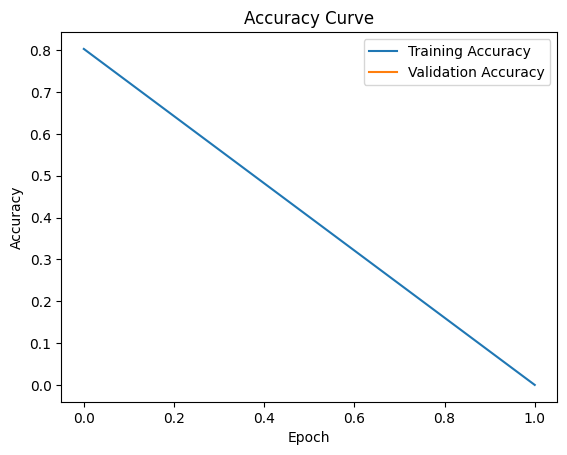

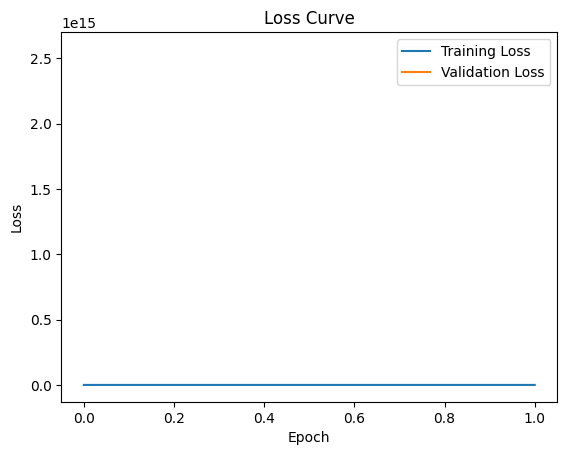

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('/content/VGG19.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Load weights
model.load_weights('/content/VGG19.weights.h5')  ### Load weights from the .weights.h5 file

# Evaluate the model
preds = model.evaluate(test_set)

# Print results
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.5944 - loss: 2536677209800704.0000
Loss = 2630466410643456.0
Test Accuracy = 0.5784946084022522


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step


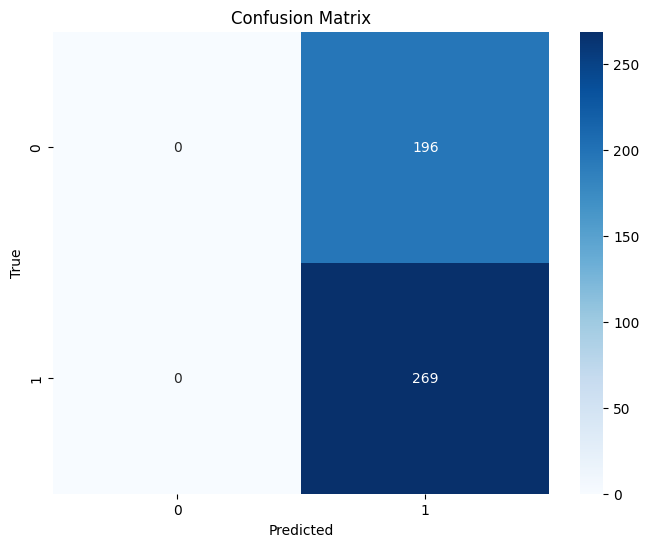

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.58      1.00      0.73       269

    accuracy                           0.58       465
   macro avg       0.29      0.50      0.37       465
weighted avg       0.33      0.58      0.42       465



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the trained model
y_pred = model.predict(test_set)  # Use model.predict instead of model.predict_generator
y_true = test_set.labels  # Ground truth labels

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# You can also generate a classification report for more detailed metrics
class_report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=test_set.class_indices.keys())
print(class_report)
